## Ki67 Positivity Analysis
Used to analyze ki67 positivity percentages in MB287 and CHLA-5

Authors: Veronika Pister & Nhan Huynh 

In [2]:
import math
import numpy as np
np.bool = np.bool_
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io, filters, exposure, morphology, measure, transform
from sklearn.mixture import GaussianMixture

In [5]:
from skimage import io, filters, exposure, morphology, measure, transform
from gold_nature_comm import *

## functions

In [16]:
def display_image(image) -> None:
    """
    show array as image
    params:
        image (np.ndarray): image to display
    """
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

In [17]:
def get_non_img_log_gate(dist, verbose=True) -> float:
    """
    params:
        dist (np.ndarray): distribution of values to gate
        verbose (bool): True for printed gate in addition to returned object
    returns:
        (int): gatinf cutoff
    """
    image = np.log(dist[dist > 0].astype("float"))
    gmm = GaussianMixture(n_components=3)
    gmm.fit(image.flatten().reshape(-1, 1))
    i0, i1, i2 = np.argsort(gmm.means_[:, 0])
    gate = np.mean([gmm.means_[i1], gmm.means_[i2]])
    if verbose:
        print(f"background mean: {np.exp(gmm.means_[i0])}")
        print(f"negative cell mean: {np.exp(gmm.means_[i1])}")
        print(f"positive cell mean: {np.exp(gmm.means_[i2])}")
        print(f"gating value: {np.exp(gate)}")

    return gate

In [27]:
def get_artifact_mask(gated_img, dataset,
             structuring_element_size=2, 
             min_hole_size=20000, min_object_size=50000, 
             title="") -> np.ndarray :
    """
    Returns binary mask of positive regions based on the manual cutoff
    
    Params:
        gated_image (np.ndarray) : pre-gated marker image
        dataset (str): title of the dataset analyzed
        structuring_element_size (int) : size of the disk to be used during closing
        min_hole_size (int) : maximum pixel size of holes in mask to be fill  
        min_object_size (int) : minimal pixel area required to keep an object
        
    Returns:
        Binary np.ndarray (mask)
    """
    structuring_element = morphology.disk(structuring_element_size)

    img_closed = morphology.binary_closing(gated_img, structuring_element)
    img_hole = morphology.remove_small_holes(img_closed, area_threshold=min_hole_size)
    img_obj = morphology.remove_small_objects(img_hole, min_size=min_object_size)
    
    save_image(img_obj,f'./mb{dataset}/{title}_obj.tif')
    
    return img_obj

In [116]:
def chi_squared_results(cell_values):
    """
    Perform chi squared testing on numeric frequencies
    params:
        cell_values (np.ndarray): frequ. of each cell belonging occurance
    """
    chi2, pval, dof, expected = chi2_contingency(cell_values)
    print('Chi-squared statistic: ', chi2)
    print('P-value: ', pval)
    print('Degrees of freedom: ', dof)
    print()
    
    row_totals = cell_values.sum(axis=1)
    col_totals = cell_values.sum(axis=0)
    total = cell_values.sum()
    expected = np.outer(row_totals, col_totals) / total


    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(
        (expected-cell_values)/col_totals * 2, 
        annot=False, fmt='d', cmap='vlag', 
        cbar=False, ax=ax, 
        xticklabels=['VSNL1+', 'VSNL1-'], 
        yticklabels=['Ki67+', 'Ki67-']
    )

    ax.set_xlabel('VSNL1 expression')
    ax.set_ylabel('Ki67 expression')
    ax.set_title('Contingency Table Heatmap')

    for i in range(cell_values.shape[0]):
        for j in range(cell_values.shape[1]):
            text = f'observed: {cell_values[i,j]}\n(expected: {expected[i,j]:.1f})'
            color = 'black'
            ax.text(j+0.5, i+0.5, text, ha='center', va='center', color=color)

    plt.show()

# Final Ki67 

## CHLA5

### Ki67 gating

In [156]:
# open quantification file 
df = pd.read_csv("./chla5_cellprofiler_ki67_quant.csv")

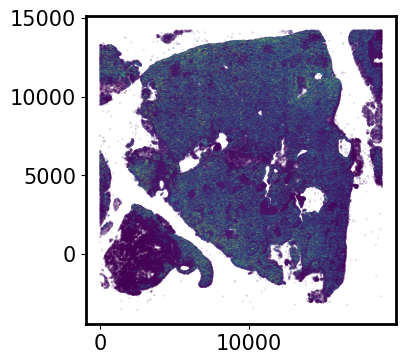

In [239]:
# plot Ki67
plt.figure(figsize=(4,4))
temp_max = max(df["Location_Center_Y"])
plt.scatter(x=df["Location_Center_X"], 
            y=temp_max/1.25 - df["Location_Center_Y"], 
            c=df["Intensity_MeanIntensity_Ki67"],
            s=0.0051, 
            vmin = np.percentile(df['Intensity_MeanIntensity_Ki67'], 1),
            vmax= np.percentile(df['Intensity_MeanIntensity_Ki67'], 99)
           )

In [158]:
# Find log gate of the Ki67 dsitribution 
nped = df.Intensity_MeanIntensity_Ki67.to_numpy()
GATE_0085 = get_non_img_log_gate(nped.astype("float"))

background mean: [0.00210985]
negative cell mean: [0.00811489]
positive cell mean: [0.00901978]
gating value: 0.00855538061535912


In [240]:
# manually adjust gate to a slightly stricter Ki67+ threshold
GATE_ADJ = 0.00865 

In [229]:
# Identify Ki67+ cells
list_NOTki67_idx = list(df[df['Intensity_MeanIntensity_Ki67'] < GATE_ADJ].index)
list_ki67_idx = list(df[df['Intensity_MeanIntensity_Ki67'] >= GATE_ADJ].index)

### VSNL1+, tissue masks

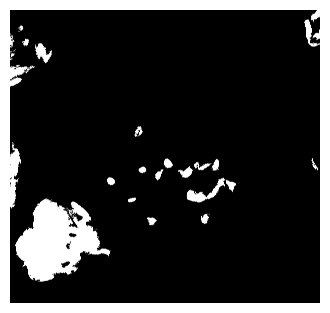

In [161]:
# get VSNL1+ mask
vsnl1_mask = io.imread('./vsnl1_mask.tif')
vsnl1_mask = vsnl1_mask > 0
display_image(vsnl1_mask)

In [241]:
# open DAPI image
folder = "/Users/veronikapister/Documents/medullo/cycif_revisions/CHLA_5/"
dapi = load_image(folder + "CHLA_AAA034404_0018-r1-w1_DAPI.tif")

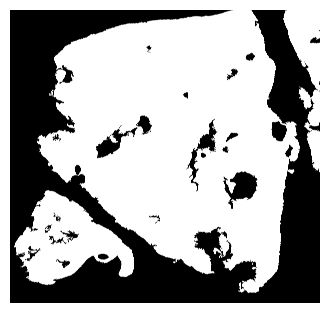

In [163]:
# generate tissue mask
dapi_gate =  dapi >0.0085

structuring_element = morphology.disk(2)  # Change the size of the disk as needed
dapi_close = morphology.closing(dapi_gate, morphology.disk(4))

dapi_hole = morphology.remove_small_holes(dapi_close, area_threshold=50000)

dapi_obj = morphology.remove_small_objects(dapi_hole, min_size=10000000)
display_image(dapi_obj)

### Identify cells in VSNL1+ regions

In [183]:
list_coordinates = list(zip(df.Location_Center_X.astype(int), 
                                              df.Location_Center_Y.astype(int)))

In [242]:
vsnl_obj = np.logical_and(vsnl1_mask, dapi_obj) 
not_vsnl_obj = np.logical_and(np.logical_not(vsnl1_mask), dapi_obj) 

list_vsnl = [vsnl_obj[point[1], point[0]] for point in list_coordinates]
list_vsnl_idx = [i for i, x in enumerate(list_vsnl) if x]

list_NOTvsnl = [not_vsnl_obj[point[1], point[0]] for point in list_coordinates]
list_NOTvsnl_idx = [i for i, x in enumerate(list_NOTvsnl) if x]

### Chi squared

In [230]:
A = set(list_ki67_idx) & set(list_vsnl_idx)
B = set(list_ki67_idx) & set(list_NOTvsnl_idx)
C = set(list_NOTki67_idx) & set(list_vsnl_idx)
D = set(list_NOTki67_idx) & set(list_NOTvsnl_idx)

ki67_map2_vsnl = np.array([
    [len(A), len(B)],# len(C)],
    [len(C), len(D)]#, len(F)]
])
ki67_map2_vsnl

array([[   634, 112350],
       [ 40727, 372790]])

In [231]:
print(ki67_map2_vsnl[0,0]/ki67_map2_vsnl[:,0].sum())
print(ki67_map2_vsnl[0,1]/ki67_map2_vsnl[:,1].sum())

0.015328449505572883
0.231582635940141


Chi-squared statistic:  10573.611559890938
P-value:  0.0
Degrees of freedom:  1



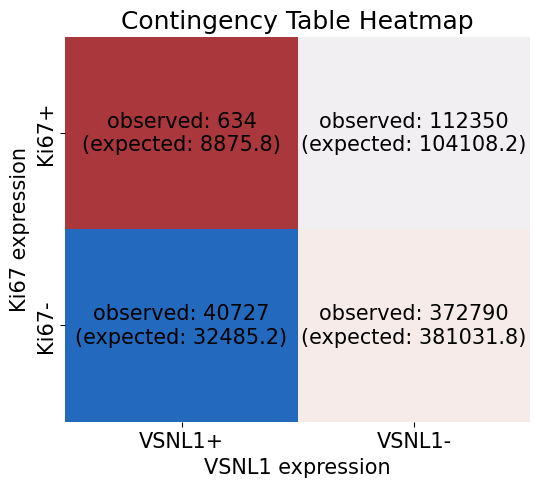

In [232]:
chi_squared_results(ki67_map2_vsnl)

## MB287
### Ki67 gating

In [243]:
# open quantification file 
df = pd.read_csv("./mb287_cellprofiler_ki67_quant.csv")

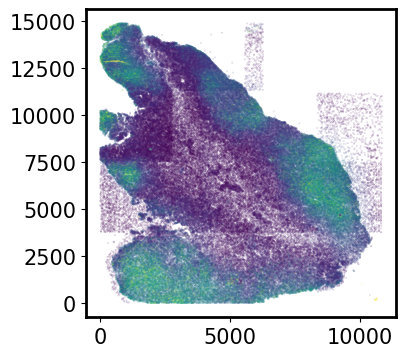

In [246]:
plt.figure(figsize=(4,4))
temp_max = max(df["Location_Center_Y"])
plt.scatter(x=df["Location_Center_X"]/1.25, 
            y=temp_max/1.25 - df["Location_Center_Y"]/1.25, 
            c=df["Intensity_MeanIntensity_Ki67"],
            s=0.0051, 
            vmax= np.percentile(df['Intensity_MeanIntensity_Ki67'], 99),
            vmin = np.percentile(df['Intensity_MeanIntensity_Ki67'], 1)
           )

In [105]:
# Find log gate of the Ki67 dsitribution 
nped = df.Intensity_MeanIntensity_Ki67.to_numpy()
GATE = get_non_img_log_gate(nped.astype("float"))

background mean: [0.00788693]
negative cell mean: [0.00802736]
positive cell mean: [0.00830559]
gating value: 0.008165292147649031


In [106]:
# Identify Ki67+ cells
list_NOTki67_idx = list(df[df['Intensity_MeanIntensity_Ki67'] < GATE_0082].index)
list_ki67_idx = list(df[df['Intensity_MeanIntensity_Ki67'] >= GATE_0082].index)

### VSNL1+, tissue masks

In [247]:
# load raw image files
folder = "/Users/veronikapister/Documents/medullo/cycif_revisions/MB287/"
vsnl = load_image(folder + "MB287_r1_VSNL1_stitched-0.tif")
map2 = load_image(folder + "MB287_r1_MAP2_stitched-0.tif")

In [248]:
# get VSNL1+ mask
MAP2_ARTIFACT_CUTOFF = 0.0162439
VSNL1_GATE = 0.00807596795
vsnl_gate =  np.logical_and(
    np.logical_not(map2>MAP2_ARTIFACT_CUTOFF),
    vsnl>VSNL1_GATE
)

vsnl1_mask = get_artifact_mask(vsnl_gate, dataset='287', title='vsnl1')

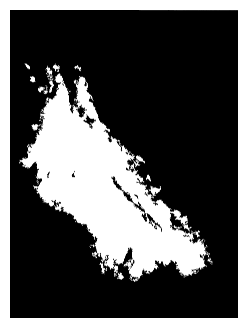

In [249]:
display_image(vsnl1_mask)

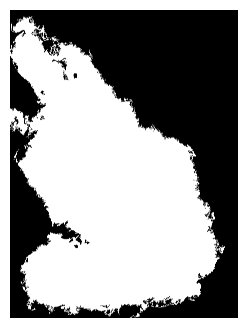

In [250]:
# get tissue mask
dapi = load_image(folder + "MB287_r2_w1_DAPI_stitched-0.tif")
dapi_gate =  np.logical_and(np.logical_not(map2>0.0162439),dapi >0.009)
dapi_mask = get_artifact_mask(dapi_gate, dataset='287', title='tissue')
display_image(dapi_mask)

### Identify cells in/not in VSNL1+ regions

In [88]:
list_coordinates = list(zip(df.Location_Center_X.astype(int), 
                                              df.Location_Center_Y.astype(int)))

In [90]:
vsnl_obj = np.logical_and(vsnl1_mask, dapi_mask) 
not_vsnl_obj = np.logical_and(np.logical_not(vsnl1_mask), dapi_mask) 

list_vsnl = [vsnl_obj[point[1], point[0]] for point in list_coordinates]
list_vsnl_idx = [i for i, x in enumerate(list_vsnl) if x]

list_NOTvsnl = [not_vsnl_obj[point[1], point[0]] for point in list_coordinates]
list_NOTvsnl_idx = [i for i, x in enumerate(list_NOTvsnl) if x]

### Chi squared results

In [102]:
A = set(list_ki67_idx) & set(list_vsnl_idx)
B = set(list_ki67_idx) & set(list_NOTvsnl_idx)
C = set(list_NOTki67_idx) & set(list_vsnl_idx)
D = set(list_NOTki67_idx) & set(list_NOTvsnl_idx)

ki67_map2_vsnl = np.array([
    [len(A), len(B)],# len(C)],
    [len(C), len(D)]#, len(F)]
])
ki67_map2_vsnl


array([[  145,  8627],
       [57113, 94888]])

Chi-squared statistic:  4665.22270806108
P-value:  0.0
Degrees of freedom:  1
Expected frequencies:  [[ 3124.07665466  5647.92334534]
 [54133.92334534 97867.07665466]]


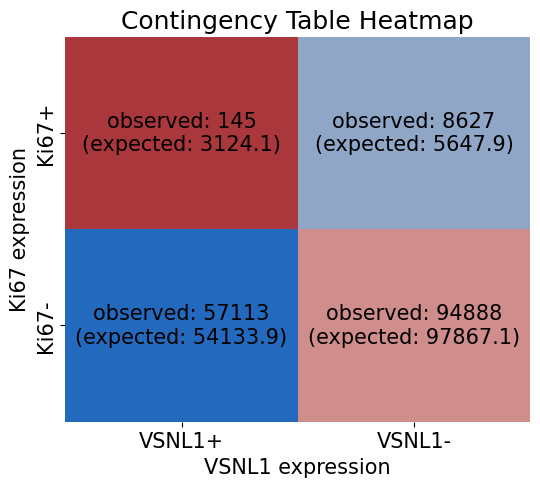

In [115]:
chi_squared_results(ki67_map2_vsnl)